In [1]:
# load required packages
library(readr)
library(dplyr)
library(ggplot2)
library(forecast)

Warning message:
"package 'readr' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'forecast' was built under R version 3.6.3"Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


In [3]:
# import data
sales <- read_csv("MonthlySales.csv")


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  month = col_date(format = ""),
  sales = col_double()
)



In [4]:
# examine dataset
str(sales)
head(sales, n = 5)

tibble [48 x 2] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ month: Date[1:48], format: "2013-01-01" "2013-02-01" ...
 $ sales: num [1:48] 14237 4520 55691 28295 23648 ...
 - attr(*, "spec")=
  .. cols(
  ..   month = col_date(format = ""),
  ..   sales = col_double()
  .. )


month,sales
2013-01-01,14236.90
2013-02-01,4519.89
2013-03-01,55691.01
2013-04-01,28295.35
2013-05-01,23648.29


Looking at the dataframe, we can see that it's a simple two column dataset with the month (as a date class) and the monthly sales in second column. The range of the data is four years, beginning January 2013 and ending December 2016.

We'll start by simply plotting our sales data against time:

`geom_smooth()` using formula 'y ~ x'


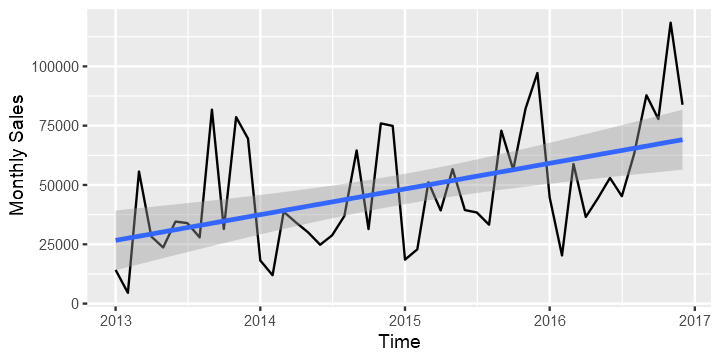

In [5]:
options(repr.plot.width = 6, repr.plot.height = 3)
ggplot(sales, aes(x = month, y = sales)) + geom_line() + geom_smooth(method = 'lm') +labs(x = "Time", y = "Monthly Sales")

Looking at the plot, we can see that the sales are highly seasonal, with higher sales in November and December, preceeded by a bump in sales in late summer / early autumn (end of season sale perhaps). We can dissect the underlying trend and the seasonality using decompose. Looking at how the difference between the revenue changes over time, an additive model seems acceptable for this dataset.

In [6]:
# convert our sales data to a time series object
salesTS <- ts(sales$sales, frequency = 12, start = c(2013,1))
class(salesTS)

[1] "ts"

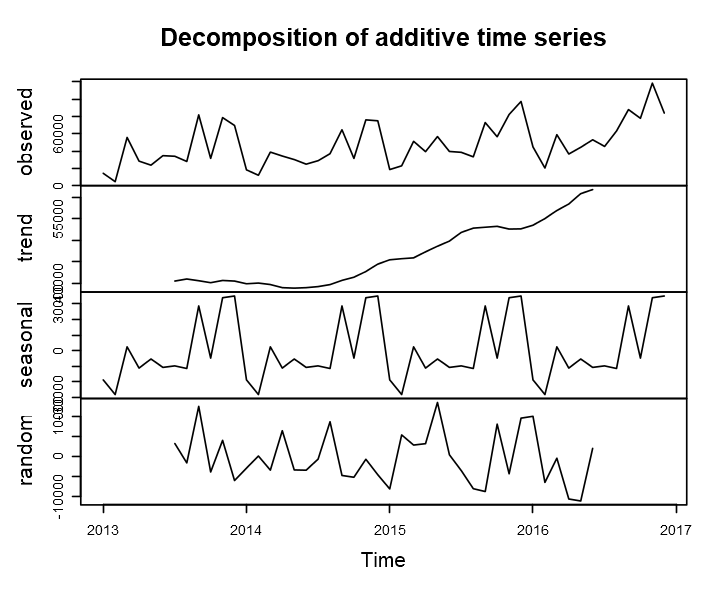

In [7]:
options(repr.plot.width = 6, repr.plot.height = 5)
salesDecomp <- decompose(salesTS)
plot(salesDecomp)

Looking at the decomposition plot, we can see that there is a good upward trend over the last couple of years, and we can see the regular, seasonal component of our data.

As we have made the assumption that we can describe these data with an additive model, we can attempt to build a forecast model using Holt-Winters exponential smoothing..

In [8]:
# log transform time series data
salesLog <- log(salesTS)

salesLogHW <- HoltWinters(salesLog)
salesLogHW

Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
HoltWinters(x = salesLog)

Smoothing parameters:
 alpha: 0.09468927
 beta : 0.1101239
 gamma: 0.5068207

Coefficients:
            [,1]
a   10.955508241
b    0.016516751
s1  -0.357929594
s2  -0.828564293
s3   0.183055096
s4  -0.151508534
s5  -0.004993629
s6  -0.082582009
s7  -0.112504324
s8  -0.006756333
s9   0.554208192
s10  0.191937689
s11  0.705228457
s12  0.558753042

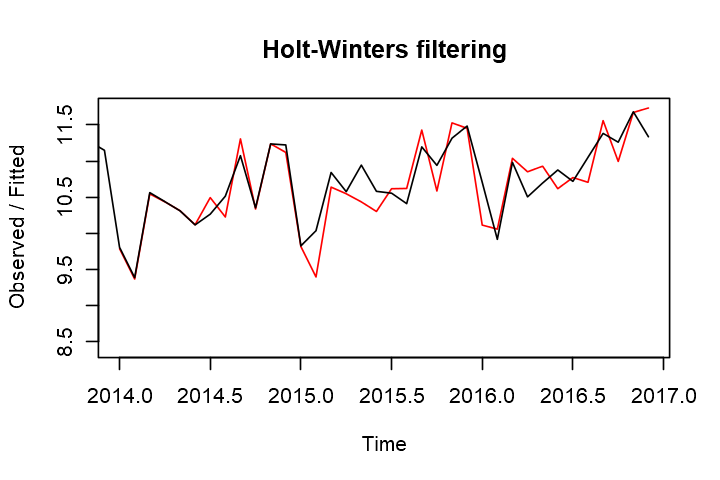

In [9]:
options(repr.plot.width = 6, repr.plot.height = 4)
plot(salesLogHW)

Looking at the plot above, we can see that the Holt-Winters prediction (red), quite closely matches our observed data (black). However, what we really want to know is what the next 12 months might look like. Let's turn to the forecast.HoltWinters function in the forecast package:

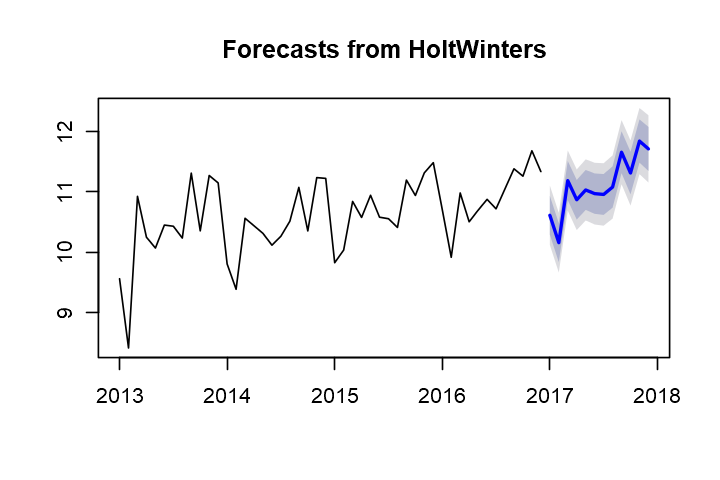

In [10]:
# forecast next year's sales
nextYearSales <- forecast(salesLogHW, h=12)
# plot
plot(nextYearSales)

In [11]:
nextYearSales

         Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
Jan 2017       10.61410 10.292457 10.93573 10.122193 11.10600
Feb 2017       10.15998  9.836567 10.48339  9.665364 10.65459
Mar 2017       11.18811 10.862575 11.51365 10.690246 11.68598
Apr 2017       10.87007 10.542017 11.19812 10.368357 11.37178
May 2017       11.03310 10.702128 11.36407 10.526923 11.53927
Jun 2017       10.97203 10.637704 11.30635 10.460724 11.48333
Jul 2017       10.95862 10.620494 11.29675 10.441500 11.47574
Aug 2017       11.08089 10.738484 11.42329 10.557228 11.60454
Sep 2017       11.65837 11.311207 12.00553 11.127431 12.18930
Oct 2017       11.31261 10.960196 11.66503 10.773638 11.85159
Nov 2017       11.84242 11.484241 12.20060 11.294631 12.39021
Dec 2017       11.71246 11.348005 12.07692 11.155073 12.26985

Looking at the output, we can see that we have our monthly forecast as well as 80% and 95% confidence intervals. As we have transformed our sales data using log, we'll want to transform those values back into our dollar amounts before we present those in our reports.

In summary,

We have used Holt-Windows exponential smoothing to forecast the sales revenue for the next 12 months. From this point, there are a number of tests that we can do to check our model and see if we can improve it.

Building a forecasting model, and our forecasts are simply based on the historical data and do not include a way of accounting for the effects of external factors. While limited, these models do provide a starting point, and can be used to generate a variable that feeds into a more complex model that does include additional variables.